In [1]:
import os
import shutil
import pathlib

import pandas as pd
import numpy as np
import cv2
from PIL import Image, ImageFilter, ImageOps, ImageDraw
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=FutureWarning)

random_seed = 0
cmap_ref = 'nipy_spectral'

In [2]:
json_path = pathlib.Path('data', 'yelp_photos', 'photos.json')
data_photos = pd.read_json(json_path, lines=True)
data_photos.head()

photo_id             business_id  \
0  zsvj7vloL4L5jhYyPIuVwg  Nk-SJhPlDBkAZvfsADtccA   
1  HCUdRJHHm_e0OCTlZetGLg  yVZtL5MmrpiivyCIrVkGgA   
2  vkr8T0scuJmGVvN2HJelEA  _ab50qdWOk0DdB6XOrBitw   
3  pve7D6NUrafHW3EAORubyw  SZU9c8V2GuREDN5KgyHFJw   
4  H52Er-uBg6rNrHcReWTD2w  Gzur0f0XMkrVxIwYJvOt2g   

                                             caption    label  
0  Nice rock artwork everywhere and craploads of ...   inside  
1                                                     outside  
2                                     oyster shooter    drink  
3                                      Shrimp scampi     food  
4                                                        food

In [3]:
data_photos.describe().T

count  unique                     top    freq
photo_id     200100  200098  _CYoxbCIKuAwpq4crHCPWg       2
business_id  200100   36680  FEXhWNCMkv22qG04E83Qjg     528
caption      200100   76413                          103366
label        200100       5                    food  108152

In [4]:
data_photos.label.unique()

array(['inside', 'outside', 'drink', 'food', 'menu'], dtype=object)

>#### On a donc 5 catégories pour lesquelles il va falloir récupèrer de 100 à 200 images

# 1. Préparation du jeu de données de travail

## 1.1 Sélection des images pour chaque catégorie

In [5]:
sample_size = 200
data_photos_selection = pd.DataFrame()
for label in data_photos.label.unique():
    print(label)
    data_photos_selection = pd.concat([data_photos_selection, data_photos[data_photos.label == label].sample(sample_size, random_state=random_seed)], axis=0)

inside
outside
drink
food
menu


In [6]:
display(data_photos_selection.head(2), data_photos_selection.shape)

photo_id             business_id  \
26366  4bCgKE0Itp0T8wQXpYsypg  B0TP0GVKZKAi05p-sTjc6w   
88249  RN1AVvw1HXLceaNJkI0GdQ  zNBtF87cr_uzqloqWdO34g   

                           caption   label  
26366  Kerry Courtney (11.16.2018)  inside  
88249                     entrance  inside

(1000, 4)

In [7]:
data_photos_selection.label.value_counts()

inside     200
outside    200
drink      200
food       200
menu       200
Name: label, dtype: int64

In [8]:
data_photos_selection.describe().T

count unique                     top freq
photo_id     1000   1000  4bCgKE0Itp0T8wQXpYsypg    1
business_id  1000    943  pAFtOcz710oLQ-e_J6AIzw    4
caption      1000    436                          529
label        1000      5                  inside  200

## 1.2 Transfère des images sélectionnées

In [9]:
src_path = pathlib.Path('data', 'yelp_photos', 'photos')
new_path = pathlib.Path('data', 'photos')

#### On supprime un éventuel ancien dossier contenant les images

In [10]:
if os.path.exists(new_path):
    for file in  os.listdir(new_path):
        os.remove(pathlib.Path(new_path, file))
    os.rmdir(new_path)

#### On crée un dossier pour stocker les images sélectionnées et on y copie les images

In [11]:
os.mkdir(new_path)

In [12]:
for photo_name in data_photos_selection.photo_id:
    src = pathlib.Path(src_path, f"{photo_name}.jpg")
    dst = pathlib.Path(new_path, f"{photo_name}.jpg")
    shutil.copyfile(src, dst)
print("Copie des images sélectionnée terminé")

Copie des images sélectionnée terminé


## 1.3 Pré-traitement des images sélectionnées

#### On supprime un éventuel ancien dossier contenant les images pré-traitées

In [13]:
preprocessed_path = pathlib.Path('data', 'photos_preprocessed')

In [14]:
if os.path.exists(preprocessed_path):
    for file in  os.listdir(preprocessed_path):
        os.remove(pathlib.Path(preprocessed_path, file))
    os.rmdir(preprocessed_path)

#### On pré-traite les images, on crée un nouveau dossier pour les stocker et on les y copie

In [15]:
os.mkdir(preprocessed_path)

data/photos/9gsifzRIZWZEQ_slmUSnIA.jpg OUTSIDE


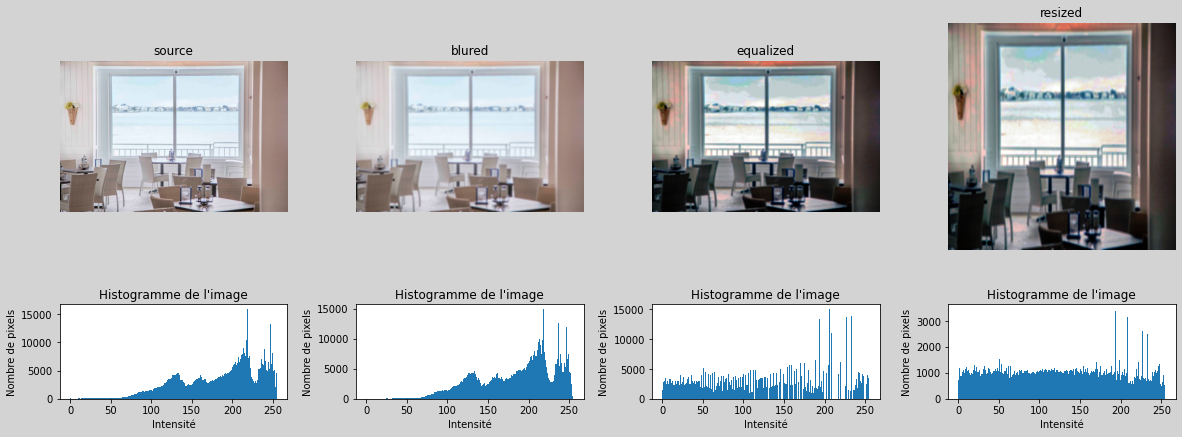

data/photos/RJufWmPFiAgKCKhf3jB-Pg.jpg DRINK


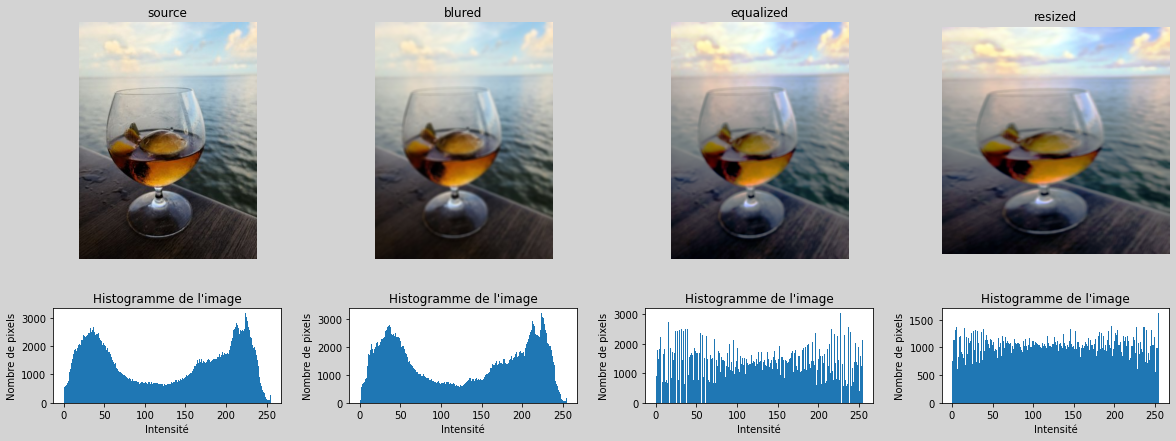

data/photos/MLILQeZOmN1klgyagfRE-A.jpg FOOD


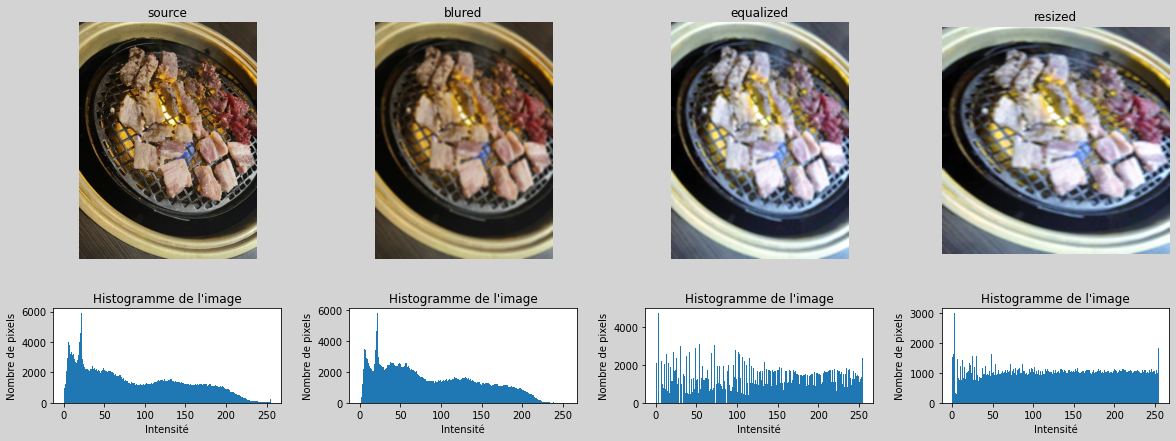

data/photos/k6x2IdfUX-Xphs2XEMz2uw.jpg MENU


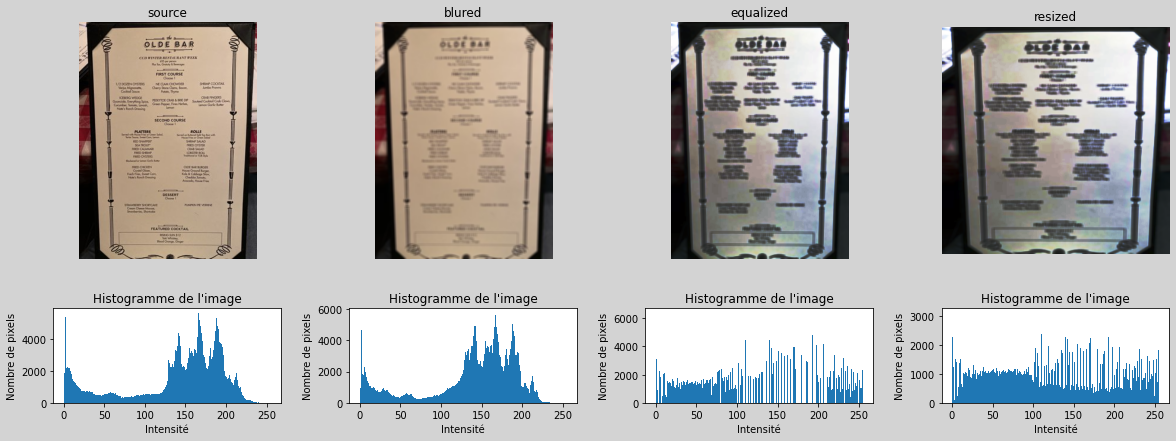

data/photos/0XrINgVTH3LtnhB5N9g-eA.jpg MENU


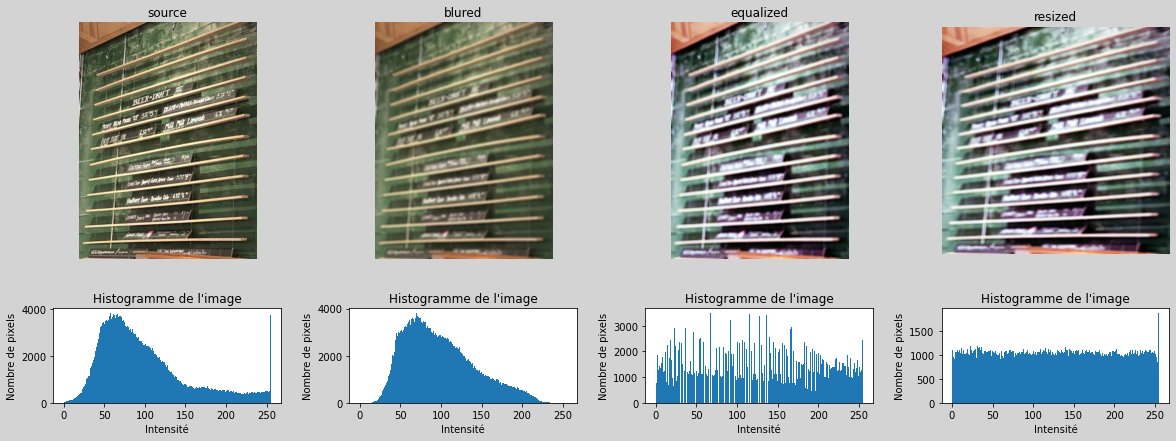

In [16]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
param_blur = 2
newsize = (300, 300)

for i, photo in data_photos_selection.iterrows():
    img_path = pathlib.Path(new_path, f"{photo.photo_id}.jpg")
    img = Image.open(img_path)
    
    # Gray
    # gray_img = ImageOps.grayscale(img)
    
    # Blur
    # blured_img = gray_img.filter(ImageFilter.BoxBlur(param_blur))
    blured_img = img.filter(ImageFilter.BoxBlur(param_blur))
    
    # Equalize
    equalized_img = ImageOps.equalize(blured_img)
    
    # Resize
    final_img = equalized_img.resize(newsize)
    
    # Save image
    export_path = pathlib.Path(preprocessed_path, f"{photo.photo_id}.jpg")
    final_img.save(export_path)

    if photo.photo_id in sample_id_show:
        print(img_path, photo.label.upper())
        fig = plt.figure(figsize=(20,7), facecolor='lightgray')
        
        #steps_show=[img, gray_img, blured_img, equalized_img, final_img]
        steps_show=[img, blured_img, equalized_img, final_img]
        steps_name=["source", "blured", "equalized", "resized"]
        
        spec = gridspec.GridSpec(
                        ncols=len(steps_show), nrows=2,
                        width_ratios=[1]*len(steps_show), wspace=0.3,
                        hspace=0.3, height_ratios=[5, 2]
                        )
        
        for i, image in enumerate(steps_show):

            fig.add_subplot(spec[i])
            plt.title(steps_name[i])
            plt.imshow(image, cmap='gray', vmin=0, vmax=255)
            plt.axis('off')

            fig.add_subplot(spec[i+len(steps_show)])
            mat = np.array(image)
            plt.title("Histogramme de l'image")
            plt.hist(mat.flatten(), bins=range(256))
            plt.xlabel('Intensité')
            plt.ylabel('Nombre de pixels')

        plt.show()

L'**histogramme** d'une image numérique est une courbe statistique représentant la répartition de ses pixels selon leur intensité. <br>Pour une image en noir et blanc, il indique en abscisse le niveau de gris (entier entre 0 et 255) et en ordonnée, le nombre de pixels ayant cette valeur.

Lorsque l'histogramme est **normalisé**, il indique en ordonnée la probabilité pi de trouver un pixel de niveau de gris i dans l'image. (ce n'est pas le cas ci-dessus)

Un **histogramme cumulé normalisé** calcule le pourcentage de pixels ayant une valeur inférieure à un niveau de gris donné. (ce n'est pas le cas ci-dessus)

# 2. Création *manuelle* des `bag of visual-words`
<img src="medias/bovw_process.jpeg" width="400">

## 2.1 Extraction de features et calcul des descripteurs des images avec SIFT, SURF, BRIEF ou ORB

La première étape pour construire un `bag of visual words` est d'effectuer une extraction des features et de calculer les descripteurs pour chaque image du jeu de données. Un descripteur est un vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images. Pour faciliter cette étape de matching *(le k-means plus bas par exemple)*, le descripteur doit présenter de nombreuses propriétés d'invariance (rotation, échelle, illumination et dans une certaine mesure les variations affines). Ainsi, les descripteurs de deux features identiques à un changement géométrique ou photométrique près doivent donc être aussi proches que possible. L'étape de matching revient alors à comparer les descripteurs.

L'un des algorithmes les plus connus est `SIFT` *(Scale Invariant Feature Transform)*, mais il est existe d'autres comme `SURF` *(Spped Up Robust Feature)*, `BRIEF` *(Binary Robust Independent Elementary Features)* ou `ORB` *(ORiented BRIEF)*.
Ces algorithmes convertissent chaque patch en un vecteur à *n* dimensions et donc après cette étape, chaque image est une collection de vecteurs de la même dimension (128 pour SIFT), où l'ordre des différents vecteurs n'a pas d'importance.

<img src="medias/bovw_extract_features.png" width="400">

In [17]:
max_features = 250

# Initialize the ORB / SIFT detector algorithm
orb = cv2.ORB_create(nfeatures=max_features, patchSize=15)
sift = cv2.SIFT_create(nfeatures=max_features) # patchSize is fixed in code (size=12σ×12σ)

data/photos_preprocessed/9gsifzRIZWZEQ_slmUSnIA.jpg OUTSIDE


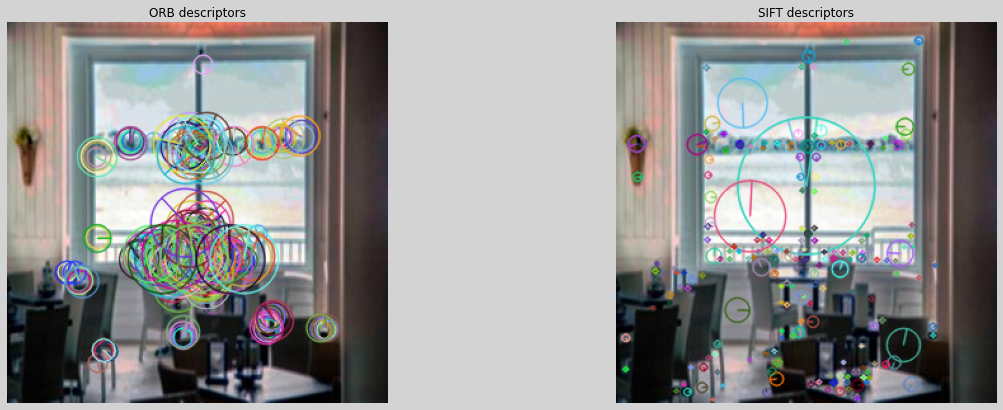

data/photos_preprocessed/RJufWmPFiAgKCKhf3jB-Pg.jpg DRINK


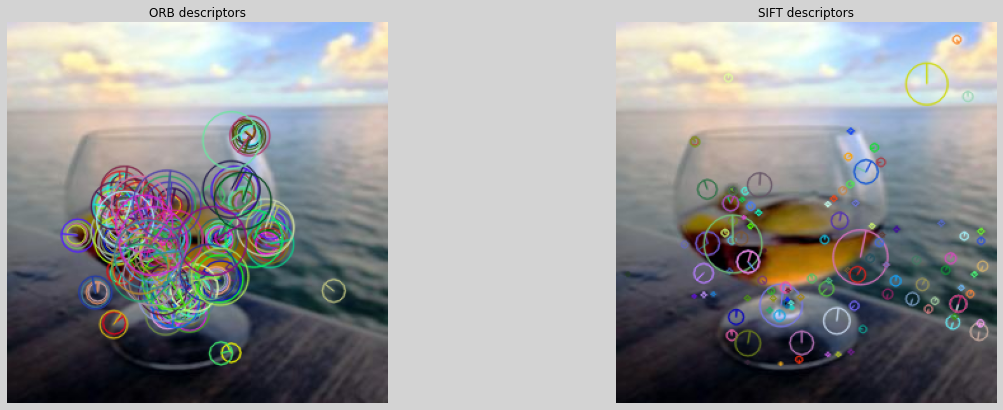

data/photos_preprocessed/MLILQeZOmN1klgyagfRE-A.jpg FOOD


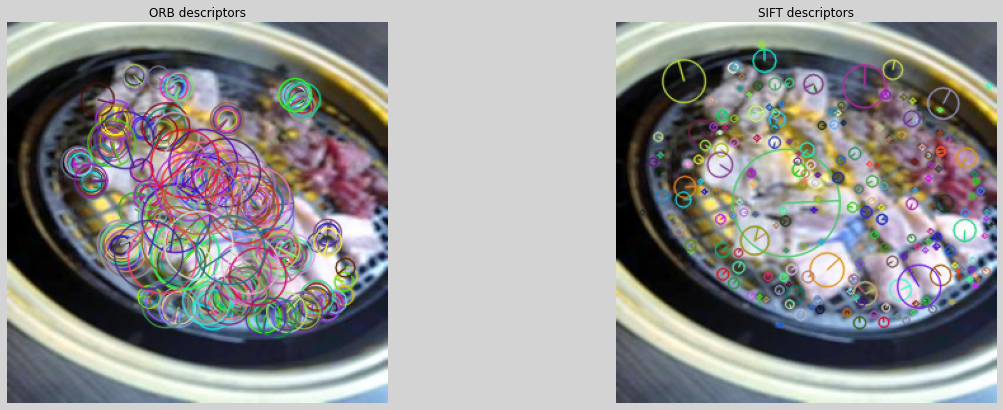

data/photos_preprocessed/k6x2IdfUX-Xphs2XEMz2uw.jpg MENU


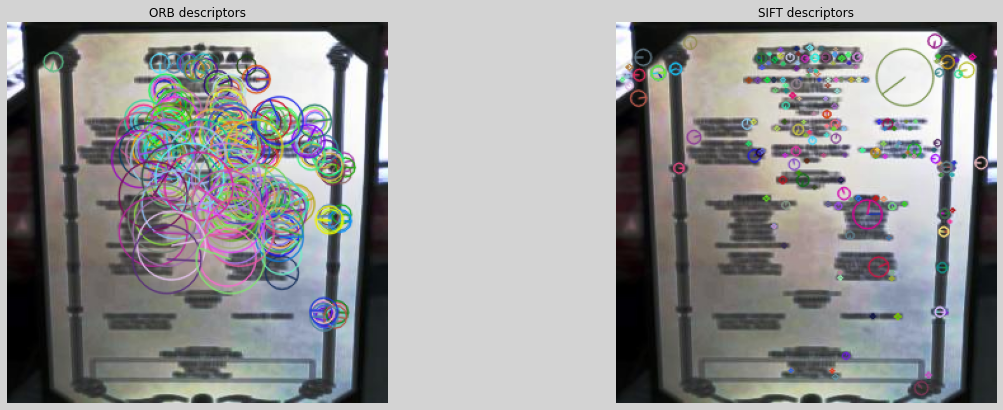

data/photos_preprocessed/0XrINgVTH3LtnhB5N9g-eA.jpg MENU


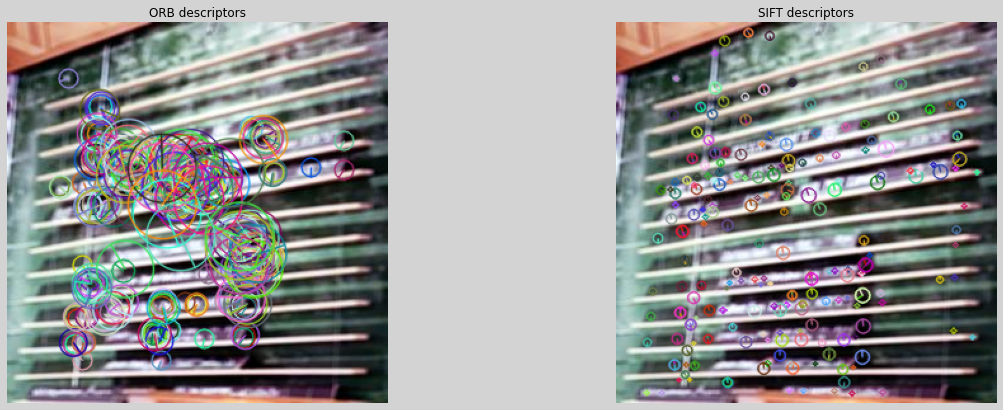

In [18]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
des_list_SIFT=[]
des_list_ORB=[]

for i, photo in data_photos_selection.iterrows():
    img_path = pathlib.Path(preprocessed_path, f"{photo.photo_id}.jpg")
    img = Image.open(img_path)
    
    # Detect the keypoints and compute the descriptors
    mat = np.array(img)
    queryKeypointsORB, queryDescriptorsORB = orb.detectAndCompute(mat,None)
    queryKeypointsSIFT, queryDescriptorsSIFT = sift.detectAndCompute(mat,None)
    
    #des_list_ORB.append((i, queryKeypointsORB, queryDescriptorsORB))
    #des_list_SIFT.append((i, queryKeypointsSIFT, queryDescriptorsSIFT))
    des_list_ORB.extend(queryDescriptorsORB)
    des_list_SIFT.extend(queryDescriptorsSIFT)
    
    if photo.photo_id in sample_id_show:
        print(img_path, photo.label.upper())
        fig = plt.figure(figsize=(20,7), facecolor='lightgray')
        
        # draw only keypoints location,not size and orientation
        plt.subplot(1,2,1)
        plt.title("ORB descriptors")
        #img_orb = cv2.drawKeypoints(mat, queryKeypointsORB, None, color=(0,255,0), flags=0)
        img_orb = cv2.drawKeypoints(mat, queryKeypointsORB, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_orb)
        plt.axis('off')
        
        plt.subplot(1,2,2)
        plt.title("SIFT descriptors")
        #img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, color=(0,255,0), flags=0)
        img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.imshow(img_sift)
        plt.axis('off')
        
        plt.show()

In [19]:
len(queryKeypointsORB), len(queryKeypointsSIFT)

(236, 250)

In [20]:
len(des_list_ORB), len(des_list_SIFT)

(246781, 244705)

In [21]:
len(des_list_ORB[0]), len(des_list_SIFT[0])

(32, 128)

## 2.2 Création du `dictionnaire de visual words` avec K-means ou un autre algorithme de clustering...

Les vecteurs générés durant l'étape d'extraction de features ci-dessus vont à présent être convertis en `visual words` *(qui sont aux images ce que les mots sont aux phrases)*. Les `visual words` ne sont rien d'autre que la représentation vectorielle de patches similaires et une fois rassemblés, produisent un **dictionnaire** similaire aux dictionnaires de mots pour les textes.

Cette étape est habituellement réalisée à l'aide d'un **k-means clustering**. 
- Chaque centre de cluster produit par *k-means* devient un *visual word*.
- Le nombre de clusters *k* correspond au nombre de *visual words* que l'on obtiendra au final.
- Le *dictionnaire de visual words* peut être appris sur des *training-sets* distincts.
- Si l'ensemble d'apprentissage est suffisamment représentatif, le livre de codes sera *universel*.
- Le *dictionnaire de visual words* est utilisé pour quantifier les features. La quantification des features signifie que le vecteur de la features est mis en correspondance avec l'index du *visual word* le plus proche dans un *dictionnaire de visual words*.

Pour résumer, chaque patches d'une image est associé à un *visual word* et l'image peut donc être représentée par l'histogramme des *visual words* *(certains revenant plus souvent que d'autres)*.

<img src="medias/bovw_create_dictionary.png" width="400">

In [22]:
from sklearn.cluster import KMeans

In [23]:
# num_clusters = data_photos.label.nunique()
num_clusters = 15
sample_size = 5000

In [24]:
X_training = pd.DataFrame(des_list_SIFT[:sample_size])

In [25]:
kmeans_SIFT = KMeans(random_state=random_seed, n_clusters=num_clusters).fit(X_training)

In [26]:
from sklearn.manifold import TSNE

def plot_TSNE(model_ref, X_ref, title='K-Means Clustering'):
    
    X_embedded = TSNE(n_components=2).fit_transform(X_ref)
    dataV=pd.DataFrame(X_embedded, columns=["D1","D2"])
    dataV['cluster']=model_ref.labels_.tolist()
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(dataV['D1'],dataV['D2'], c=dataV['cluster'], s=50, cmap=cmap_ref, marker='+')
    plt.colorbar(scatter)
    ax.set_title(title)
    ax.set_xlabel('Dimention 1')
    ax.set_ylabel('Dimention 2')
    plt.show()

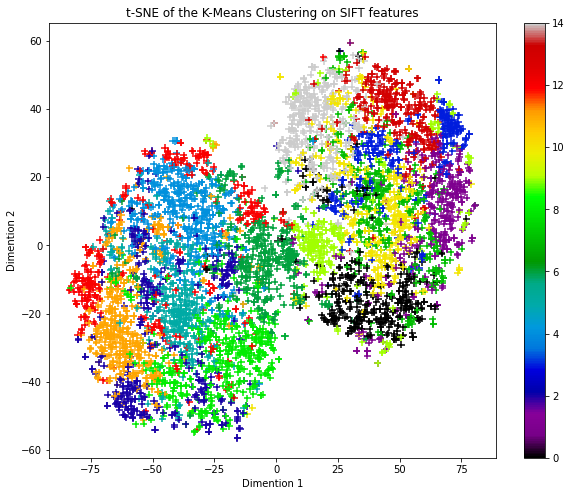

In [27]:
plot_TSNE(kmeans_SIFT, X_training, title="t-SNE of the K-Means Clustering on SIFT features")

#### Essayons de déterminer le nombre de visual-words idéal *k*

In [28]:
from yellowbrick.cluster import KElbowVisualizer

In [29]:
from tqdm import tqdm

2it [1:47:20, 3220.37s/it]


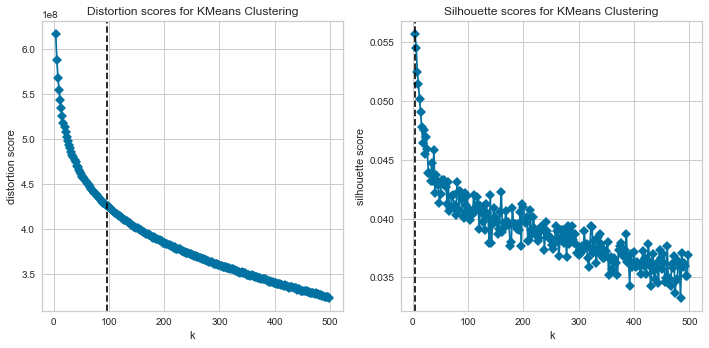

In [51]:
methods = ['distortion', 'silhouette'] #, 'calinski_harabasz']
kmeans = KMeans(random_state=random_seed)

fig = plt.figure(figsize=(15, 5))
for i, m in tqdm(enumerate(methods)):
    ax = plt.subplot(1, 3, i+1)
    visualizer = KElbowVisualizer(kmeans, k=range(4, 500, 2), metric=m, timings=False)
    visualizer.fit(X_training)
    plt.title(f"{m.title()} scores for KMeans Clustering")
    ax.set_ylabel(f'{m} score')
    ax.set_xlabel('k')
    #visualizer.show();

plt.tight_layout()
plt.show()

>#### Ce n'est pas très probant... et si l'on suit la recommandation il faudrait choisir environ 95 visual-words d'après le distrotion score ou 4 d'après le silhouette score.

#### Essayons de séparer notre dataset en 95 groupes

In [30]:
num_clusters = 95

In [31]:
kmeans_SIFT = KMeans(random_state=random_seed, n_clusters=num_clusters).fit(X_training)

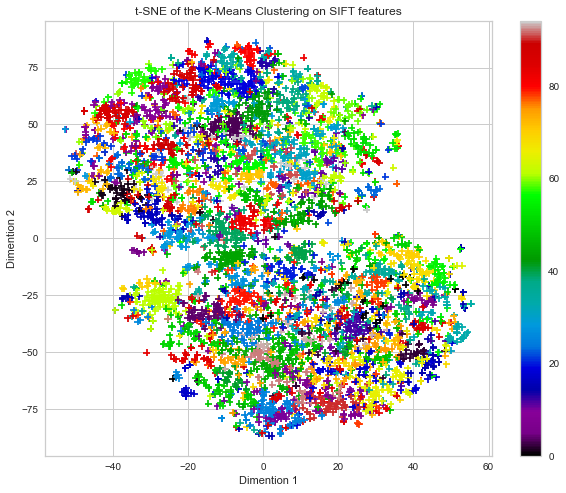

In [32]:
plot_TSNE(kmeans_SIFT, X_training, title="t-SNE of the K-Means Clustering on SIFT features")

>#### Il y a visiblement des regroupements de features, mais c'est assez difficile de les distinguer car il y a beaucoup de groupes

## 2.3 Construction des histogrammes ou `Bag of visual words`

#### Ajoutons une fonction pour créer une grille de features

In [33]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols
    h_space, w_space = 10, 5
    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*(w+w_space)-w_space, rows*(h+h_space)))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        sub_img = Image.new('RGB', size=(w, h+h_space))
        sub_img.paste(img, box=(0, h_space))
        draw = ImageDraw.Draw(sub_img)
        txt = f"{i+1}"
        ts = draw.textlength(txt)
        draw.text(((w-ts)/2,0),txt,(255,255,255), align='center')
        grid.paste(sub_img, box=(i%cols*(w+w_space), i//cols*(h+h_space)))
    return grid

data/photos_preprocessed/0XrINgVTH3LtnhB5N9g-eA.jpg MENU


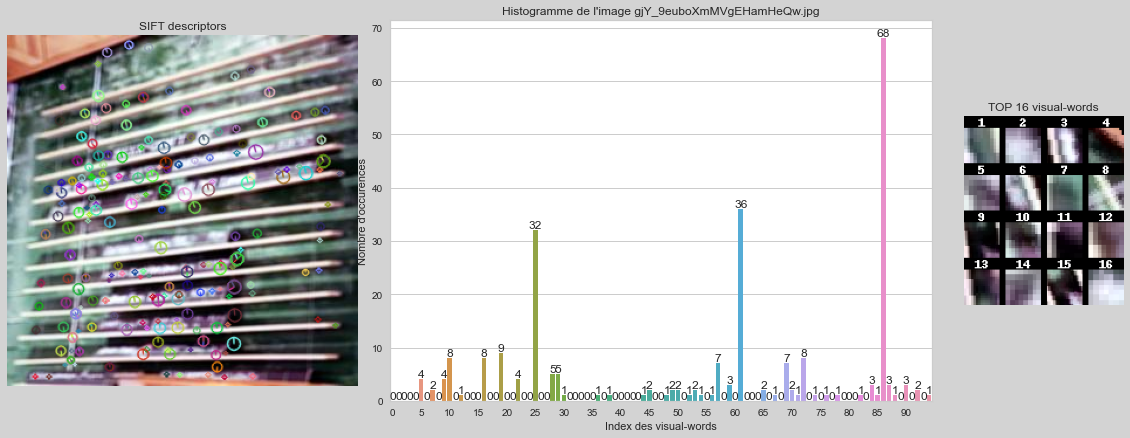

data/photos_preprocessed/k6x2IdfUX-Xphs2XEMz2uw.jpg MENU


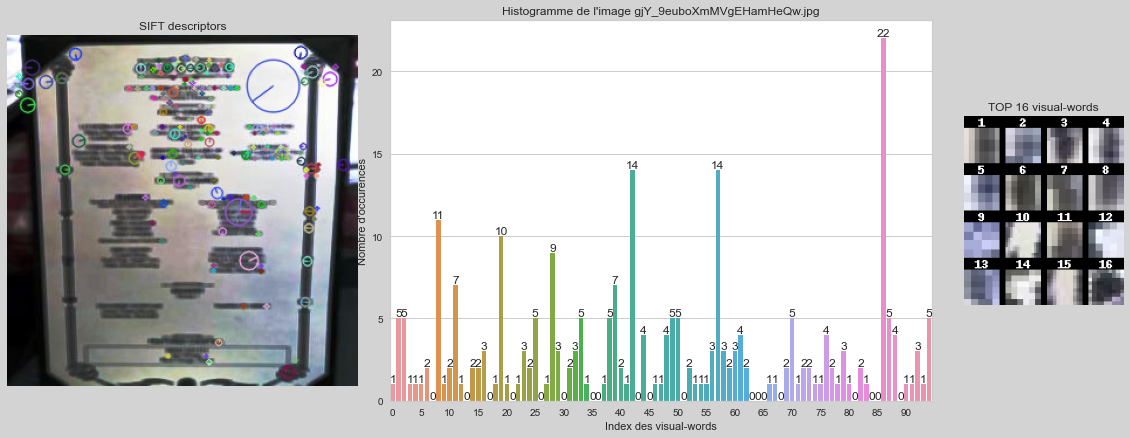

data/photos_preprocessed/9gsifzRIZWZEQ_slmUSnIA.jpg MENU


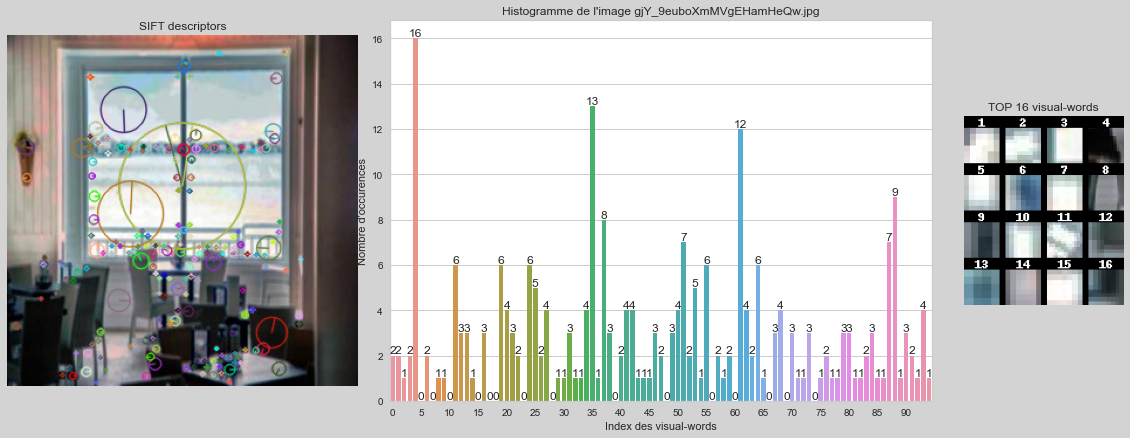

data/photos_preprocessed/RJufWmPFiAgKCKhf3jB-Pg.jpg MENU


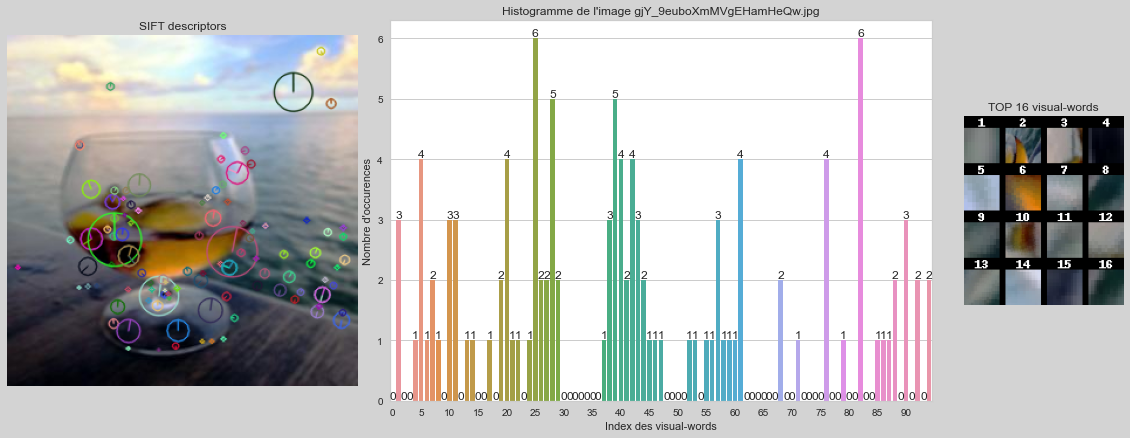

data/photos_preprocessed/MLILQeZOmN1klgyagfRE-A.jpg MENU


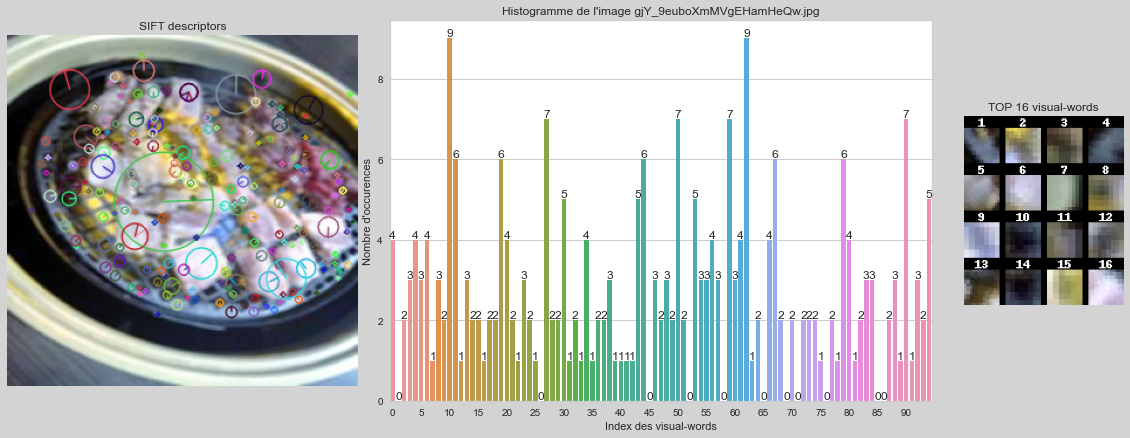

In [34]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
root_num_top = 4

for photo_id in sample_id_show:
    
    fig = plt.figure(figsize=(20,7), facecolor='lightgray')
    
    img_path = pathlib.Path(preprocessed_path, f"{photo_id}.jpg")
    img = Image.open(img_path)
    
    # Detect the keypoints and compute the descriptors
    mat = np.array(img)
    #queryKeypointsORB, queryDescriptorsORB = orb.detectAndCompute(mat,None)
    queryKeypointsSIFT, queryDescriptorsSIFT = sift.detectAndCompute(mat,None)
    
    # Get visual-words for the histogramm
    preds = pd.DataFrame(kmeans_SIFT.predict(queryDescriptorsSIFT))
    select = pd.DataFrame(preds.value_counts(sort=False), columns=['count']).reset_index().rename(columns={0:'index'})
    select.set_index('index', inplace=True)
    select = select.reindex(list(range(0,select.index.max()+1)),fill_value=0)
    
    # print title
    print(img_path, photo.label.upper())
    
    select_top = select.sort_values('count', ascending=False)[:root_num_top**2]
        
    # draw only keypoints location,not size and orientation
    plt.subplot(1,6,(1,2))
    
    plt.title("SIFT descriptors")
    img_sift = cv2.drawKeypoints(mat, queryKeypointsSIFT, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(img_sift)
    plt.axis('off')
        
    # draw visual-words histogram
    plt.subplot(1,6,(3,5))
    
    ax = sns.barplot(data=select.T)
    ax.bar_label(ax.containers[0])
    new_ticks = [i.get_text() for i in ax.get_xticklabels()]
    labels_modulo=5
    plt.xticks(range(0, len(new_ticks), labels_modulo), new_ticks[::labels_modulo], rotation=0)
    plt.ylabel("Nombre d'occurences")
    plt.xlabel("Index des visual-words")
    plt.title(f"Histogramme de l'image {photo.photo_id}.jpg")
    
    # draw visual-words
    grid_imgs = []
    for j in range(0,root_num_top**2):
        index = select_top.index[j]
        
        # Select one of the multiple patches as visual-word representation
        id = preds[preds.values == index].sample(1, random_state=random_seed).index[0]

        # Get the patch infos
        (x_s, y_s) = queryKeypointsSIFT[id].pt
        size_s = queryKeypointsSIFT[id].size
        angle_s = queryKeypointsSIFT[id].angle

        # SIFT Crop
        left_s = x_s-size_s
        right_s = x_s+size_s
        top_s = y_s-size_s
        bottom_s = y_s+size_s
        
        img_copy = img.copy().rotate(-angle_s, center=(x_s, y_s))
        img_crop_s = img_copy.crop((left_s, top_s, right_s, bottom_s)).resize((30,30), Image.Resampling.NEAREST)
        
        # Append to grid list
        grid_imgs.append(img_crop_s)
        
    plt.subplot(1,6,6)
    plt.title(f"TOP {root_num_top**2} visual-words")
    plt.imshow(image_grid(grid_imgs, rows=root_num_top, cols=root_num_top))
    plt.axis('off')
        
    plt.show()

## 2.4 Classification supervisée

C'est la dernière étape de notre méthode de résolution : l'objectif est d'apprendre les règles de décision permettant d'assigner correctement une représentation bag-of-features à une classe.

Cela signifie qu'on va entraîner un algorithme d'apprentissage supervisé sur les bag-of-features construits à l'étape 2.3. 

# 3. Création *automatique* des `bag of visual-words` avec un CNN pré-entrainé

Les réseaux de neurones convolutifs *(CNN)* ont une méthodologie similaire à celle des méthodes traditionnelles d'apprentissage supervisé : ils reçoivent des images en entrée, détectent les features de chacune d'entre elles, puis entraînent un classifieur dessus. Cependant, **les features sont apprises automatiquement et s'adaptent au problème donné !**

En effet, les CNN réalisent eux-mêmes tout le boulot fastidieux d'extraction et description de features : lors de la phase d'entraînement l'erreur de classification est minimisée afin d'optimiser les paramètres du classifieur ET les features ! De plus, l'architecture spécifique du réseau permet d'extraire des features de différentes complexités, des plus simples au plus sophistiquées.

- `Couche de Convolution`: consiste à repérer la présence d'un ensemble de features dans les images reçues en entrée.
- `Couche de Pooling`: consiste à réduire la taille des images, tout en préservant leurs caractéristiques importantes.
- `Couche de correction ReLU`: remplace donc toutes les valeurs négatives reçues en entrées par des zéros. Elle joue le rôle de fonction d'activation.
- `Couche fully-connected`: constitue toujours la dernière couche d'un réseau de neurones *(convolutif ou non)*. La dernière couche fully-connected permet de classifier l'image en entrée du réseau parmi les N catégories possibles.

Pour calculer les probabilités, la couche `fully-connected` multiplie chaque élément en entrée *(issus de la couche de correction ReLU)* par un poids, fait la somme, puis applique une fonction d'activation *(logistique si N=2, softmax si N>2)*

----

Les features de la couche de convolution sont appris par le réseau de neurones lors de la phase d'entraînement:
- La première couche de convolution apprend des features simples qui représentent des éléments de structure rudimentaires de l'image (contours, coins...).
- Plus les couches de convolution sont hautes *(c'est-à-dire loin de l'entrée du réseau)*, plus les features apprises sont complexes : celles-ci se composent des features plus simples des couches précédentes.

Un carré est un exemple de feature complexe, formée de contours et de coins qui sont des features plus simples. 

In [54]:
warnings.filterwarnings("ignore", message=".* Could not load dynamic library(.|\n)*") # supports regular expressions

In [55]:
from keras.applications import EfficientNetV2S, VGG16
from keras.layers import Dropout, GlobalAveragePooling2D, Dense, Flatten
from keras import Model
from keras.applications.efficientnet_v2 import preprocess_input

from tensorflow.keras.utils import load_img, img_to_array, image_dataset_from_directory
from tensorflow import keras

---
---

In [56]:
from tensorflow import keras

### Prepare targets

In [57]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [58]:
le = LabelEncoder()
img_labels = le.fit_transform(data_photos_selection.label)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(1000, 5)

### Prepare images

In [59]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [60]:
sample_id_show = data_photos_selection.photo_id.sample(5, random_state=random_seed).to_list()
images = []
img_array = np.empty((0, 224, 224, 3), int)

for i, photo in data_photos_selection.iterrows():
    img_path = pathlib.Path(new_path, f"{photo.photo_id}.jpg")   
    img = load_img(img_path, target_size=(224,224))  # Charger l'image
    img = img_to_array(img)
    img_array = np.append(img_array, np.array([img]), axis=0)
    
img_array.shape

(1000, 224, 224, 3)

### Split the dataset 

In [61]:
from sklearn.model_selection import train_test_split

In [62]:
num_samples = 1000

In [63]:
X_train_full, X_test, y_train_full, y_test = train_test_split(img_array[:num_samples], img_labels[:num_samples], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=X_test.shape[0], random_state=42)

In [64]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((600, 224, 224, 3), (200, 224, 224, 3), (600, 5), (200, 5))

In [65]:
assert(X_valid.shape[0] == X_test.shape[0])

In [66]:
assert(img_array[:num_samples].shape[0] == X_train.shape[0] + X_valid.shape[0] + X_test.shape[0])

In [67]:
print(f"Unique values for Train-set: {pd.Series(np.argmax(y_train,1)).unique()}, Valid-set:{pd.Series(np.argmax(y_valid,1)).unique()}, Test-set:{pd.Series(np.argmax(y_test,1)).unique()}")

Unique values for Train-set: [3 4 0 1 2], Valid-set:[1 2 4 0 3], Test-set:[0 1 3 2 4]


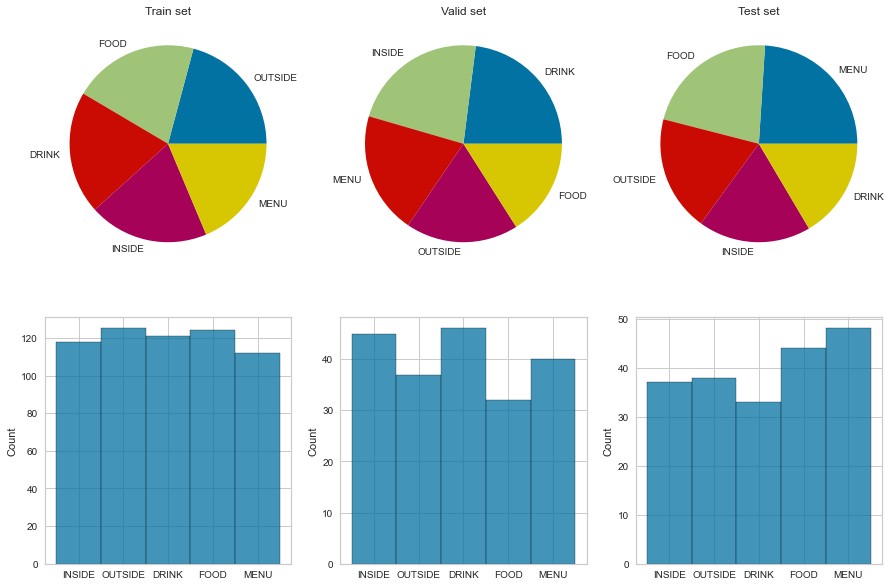

In [68]:
fig = plt.figure(figsize=[15,10])
label_names = {i:l.upper() for i,l in enumerate(data_photos_selection.label.unique())}

for i, setname in enumerate(['train', 'valid', 'test']):
    plt.subplot(2,3,i+1)
    ref1 = pd.Series(np.argmax(eval(f'y_{setname}'),1)).sort_values()
    check = ref1.value_counts()
    plt.pie(list(check), labels=check.keys().map(label_names))
    plt.title(f"{setname} set".capitalize())
    
    plt.subplot(2,3,i+4)
    sns.histplot(ref1.map(label_names))

plt.show()

### Prepare generators

In [69]:
from keras.preprocessing.image import ImageDataGenerator

In [70]:
from keras.applications.vgg16 import preprocess_input

In [71]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
train_datagen

In [72]:
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing
valid_datagen

> #### On peut aussi faire des générators avec beaucoup plus de transformations

### Initialize the train & valid generators from the numpy arrays

In [73]:
gen_batch_size=32

In [74]:
train_ds = train_datagen.flow(
    x=X_train,
    y=y_train,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [75]:
valid_ds = valid_datagen.flow(
    x=X_valid,
    y=y_valid,
    batch_size=gen_batch_size,
    shuffle=True,
)

In [76]:
test_ds = valid_datagen.flow(
    x=X_test,
    y=y_test,
    batch_size=gen_batch_size,
    shuffle=True,
)

### Prepare & Train model

In [59]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
    plt.plot(history.history['val_categorical_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [60]:
def get_best_model_from_history(hist):
    best_epoch = np.argmax(hist.history['val_categorical_accuracy'],0) + 1
    best_acc = hist.history['val_categorical_accuracy'][best_epoch-1]
    return f'model2extra.epoch{best_epoch}-categorical_accuracy{best_acc:.2f}.hdf5'

In [61]:
def apply_strategy(model, strategy, keep_layers=0):
    
    ### Stratégie #1 : fine-tuning total
    # C'est une stratégie adaptée **si l'on a un jeu de données assez conséquent**
    
    # All layers can continue the training

    if strategy == 'partial_fine_tuning':
        for layer in model.layers:
            layer.trainable = True

    ### Stratégie #2 : extraction de features
    # C'est une stratégie adaptée **si l'on a peu de données** et que 
    # **les images sont similaires** à celles utilisées pour le pre-training du CNN utilisé

    # None of the layers can continue the training, but the output layer
    # `trainable=True` is supposed to be the default for all layers
    # (if you applied another strategy, reset them)

    elif strategy == 'features_extraction':
        for layer in model.layers:
            layer.trainable = False

    ### Stratégie #3 : fine-tuning partiel
    # C'est une stratégie adaptée **si l'on a peu de données** et que 
    # **les images ne sont PAS similaires** à celles utilisées pour le pre-training du CNN utilisé

    # The top layers can't be trained anymore
    # `trainable=True` is supposed to be the default for all layers 
    # (if you applied another strategy, reset them)

    elif strategy == 'total_fine_tuning':
        for layer in model.layers[:keep_layers]:
            layer.trainable = False
            
    else:
        print(f"Unknown strategy {strategy}")

#### Define Optimizer & Loss

In [62]:
f_opti = keras.optimizers.Adam(learning_rate=0.0005)

In [63]:
f_loss = keras.losses.CategoricalCrossentropy(from_logits=False)

#### Init model

In [64]:
def architecture_vgg16():
    
    cnn_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    
    # Comme on a supprimés les derniers layers, il faut les reconstruire
    x = cnn_model.output
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    output_layer = Dense(5, activation='softmax')(x)
    
    model = keras.Model(cnn_model.input, output_layer)
    return model

In [65]:
model_vgg = architecture_vgg16()
apply_strategy(model_vgg, 'total_fine_tuning', keep_layers=20)
for layer in model_vgg.layers:
    print(f"{layer.name:40} \t--> trainable: {layer.trainable}")

2022-07-07 18:13:44.226397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/valkea/Dev/OpenClassrooms/Projets_AI/P6/venvP6/lib/python3.8/site-packages/cv2/../../lib64:
2022-07-07 18:13:44.226450: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-07 18:13:44.226478: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (valkea-XPS): /proc/driver/nvidia/version does not exist
2022-07-07 18:13:44.227298: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler fla

input_1                                  	--> trainable: False
block1_conv1                             	--> trainable: False
block1_conv2                             	--> trainable: False
block1_pool                              	--> trainable: False
block2_conv1                             	--> trainable: False
block2_conv2                             	--> trainable: False
block2_pool                              	--> trainable: False
block3_conv1                             	--> trainable: False
block3_conv2                             	--> trainable: False
block3_conv3                             	--> trainable: False
block3_pool                              	--> trainable: False
block4_conv1                             	--> trainable: False
block4_conv2                             	--> trainable: False
block4_conv3                             	--> trainable: False
block4_pool                              	--> trainable: False
block5_conv1                             	--> trainable

2022-07-07 18:13:44.940672: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


In [66]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Fit model

In [67]:
from keras.callbacks import ModelCheckpoint

In [68]:
def fit_and_save(model, train_ds, valid_ds, name="model"):
    
    filepath = output_path+name+'.epoch{epoch:02d}-categorical_accuracy{val_categorical_accuracy:.2f}.hdf5'
    #filepath = output_path+name+'.epoch{epoch:02d}-categorical_accuracy.hdf5'
    checkpoint = ModelCheckpoint(filepath=filepath, 
                             #monitor='val_loss',
                             #mode='min'
                             #monitor='val_auc',
                             monitor='val_categorical_accuracy',
                             mode='max',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             )
    # Compile model
    model.compile(optimizer=f_opti, loss=f_loss, metrics=[keras.metrics.CategoricalAccuracy()])

    # Save model
    model.save(output_path+name+".h5")

    # Fit model
    history = model.fit(
        train_ds,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        validation_steps=validation_steps,
        callbacks=[TqdmCallback(), checkpoint],
        verbose=1,
    )

    # Save weights
    model_json = model.to_json()
    with open(output_path+name+".json", "w") as yaml_file:
        yaml_file.write(model_json)

    return history

In [69]:
from tqdm.keras import TqdmCallback

In [72]:
batch_size=4
epochs=10
steps_per_epoch=10
validation_steps=50
output_path = 'models/'
# Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches 

In [73]:
history1 = fit_and_save(model_vgg, train_ds, valid_ds, name="model_vgg")

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/10


2022-07-07 18:15:09.709799: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.
2022-07-07 18:15:09.756881: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 411041792 exceeds 10% of free system memory.


10/10 [==============================] - ETA: 0s - loss: 75.1116 - categorical_accuracy: 0.4904WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_categorical_accuracy improved from -inf to 0.81000, saving model to models/model_vgg.epoch01-categorical_accuracy0.81.hdf5
10/10 [==============================] - 80s 8s/step - loss: 75.1116 - categorical_accuracy: 0.4904 - val_loss: 4.5066 - val_categorical_accuracy: 0.8100
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 2.1542 - categorical_accuracy: 0.9006

KeyError: 'Failed to format this callback filepath: "models/model_vgg.epoch{epoch:02d}-categorical_accuracy{val_categorical_accuracy:.2f}.hdf5". Reason: \'val_categorical_accuracy\''

In [ ]:
summarize_diagnostics(history1)

---
---

In [ ]:
X = pd.DataFrame(queryDescriptorsORB)

In [ ]:
kmeans_ORB = KMeans(random_state=random_seed, n_clusters=num_clusters).fit(X)

In [ ]:
get_clustering_scores("Kmeans [basic]",  model=kmeans_ORB, X_ref=X, register=True)

In [ ]:
plot_TSNE(kmeans_ORB, X, title="t-SNE of the K-Means Clustering on ORB features")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(queryDescriptorsSIFT[100].reshape(4,32), cmap='gray', vmin=0, vmax=255)
plt.show()

In [ ]:
len(queryDescriptorsSIFT[0])